In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.utils import make_grid
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from model import *

In [3]:
# Initialize the D3PM model with the same parameters as during training
N = 2  # Number of classes per pixel (should match training)
num_timesteps = 1000  # Should match training
hybrid_loss_coeff = 0.0  # Should match training

# Initialize the model
d3pm = D3PM(DummyX0Model(1, N), num_timesteps, num_classes=N, hybrid_loss_coeff=hybrid_loss_coeff).cuda()

In [4]:
# Step 2: Load the Saved State Dictionary
model_state_dict = torch.load('d3pm_checkpoint_ising_1500.pth')
d3pm.x0_model.load_state_dict(model_state_dict['model_state_dict']);

# Step 3: Set the Model to Evaluation Mode
d3pm.eval();

/tmp/ipykernel_4181707/196708465.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load('d3pm_checkpoint_ising_1500.pth')


In [5]:
def sample_with_replicates(d3pm, num_conditions, num_replicates, N=2):
    # Create repeated conditions
    cond = torch.repeat_interleave(torch.arange(num_conditions).cuda(), num_replicates)
    
    # Create noise for all samples
    total_samples = num_conditions * num_replicates
    init_noise = torch.randint(0, N, (total_samples, 1, 32, 32)).cuda()
    
    # Generate samples
    images = d3pm.sample_with_image_sequence(init_noise, cond, stride=40)
    
    return images, cond

def plot_diffusion_grid_with_replicates(tensor_images, cond, num_replicates, figsize=(15, 15)):
    # Expect tensor of shape [batch_size, channels, height, width]
    assert len(tensor_images.shape) == 4
    
    num_conditions = len(torch.unique(cond))
    
    # Create a grid with num_conditions rows and num_replicates columns
    fig, axes = plt.subplots(num_conditions, num_replicates, figsize=figsize)
    
    # Plot each image with subtitles
    for i in range(num_conditions):
        for j in range(num_replicates):
            idx = i * num_replicates + j
            img = tensor_images[idx, 0].cpu().numpy()
            
            if num_conditions == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
                
            ax.imshow(img, cmap='gray')
            
            # Only add condition label for the first replicate in each row
            if j == 0:
                ax.set_title(f'Cond: {cond[idx].item()}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    


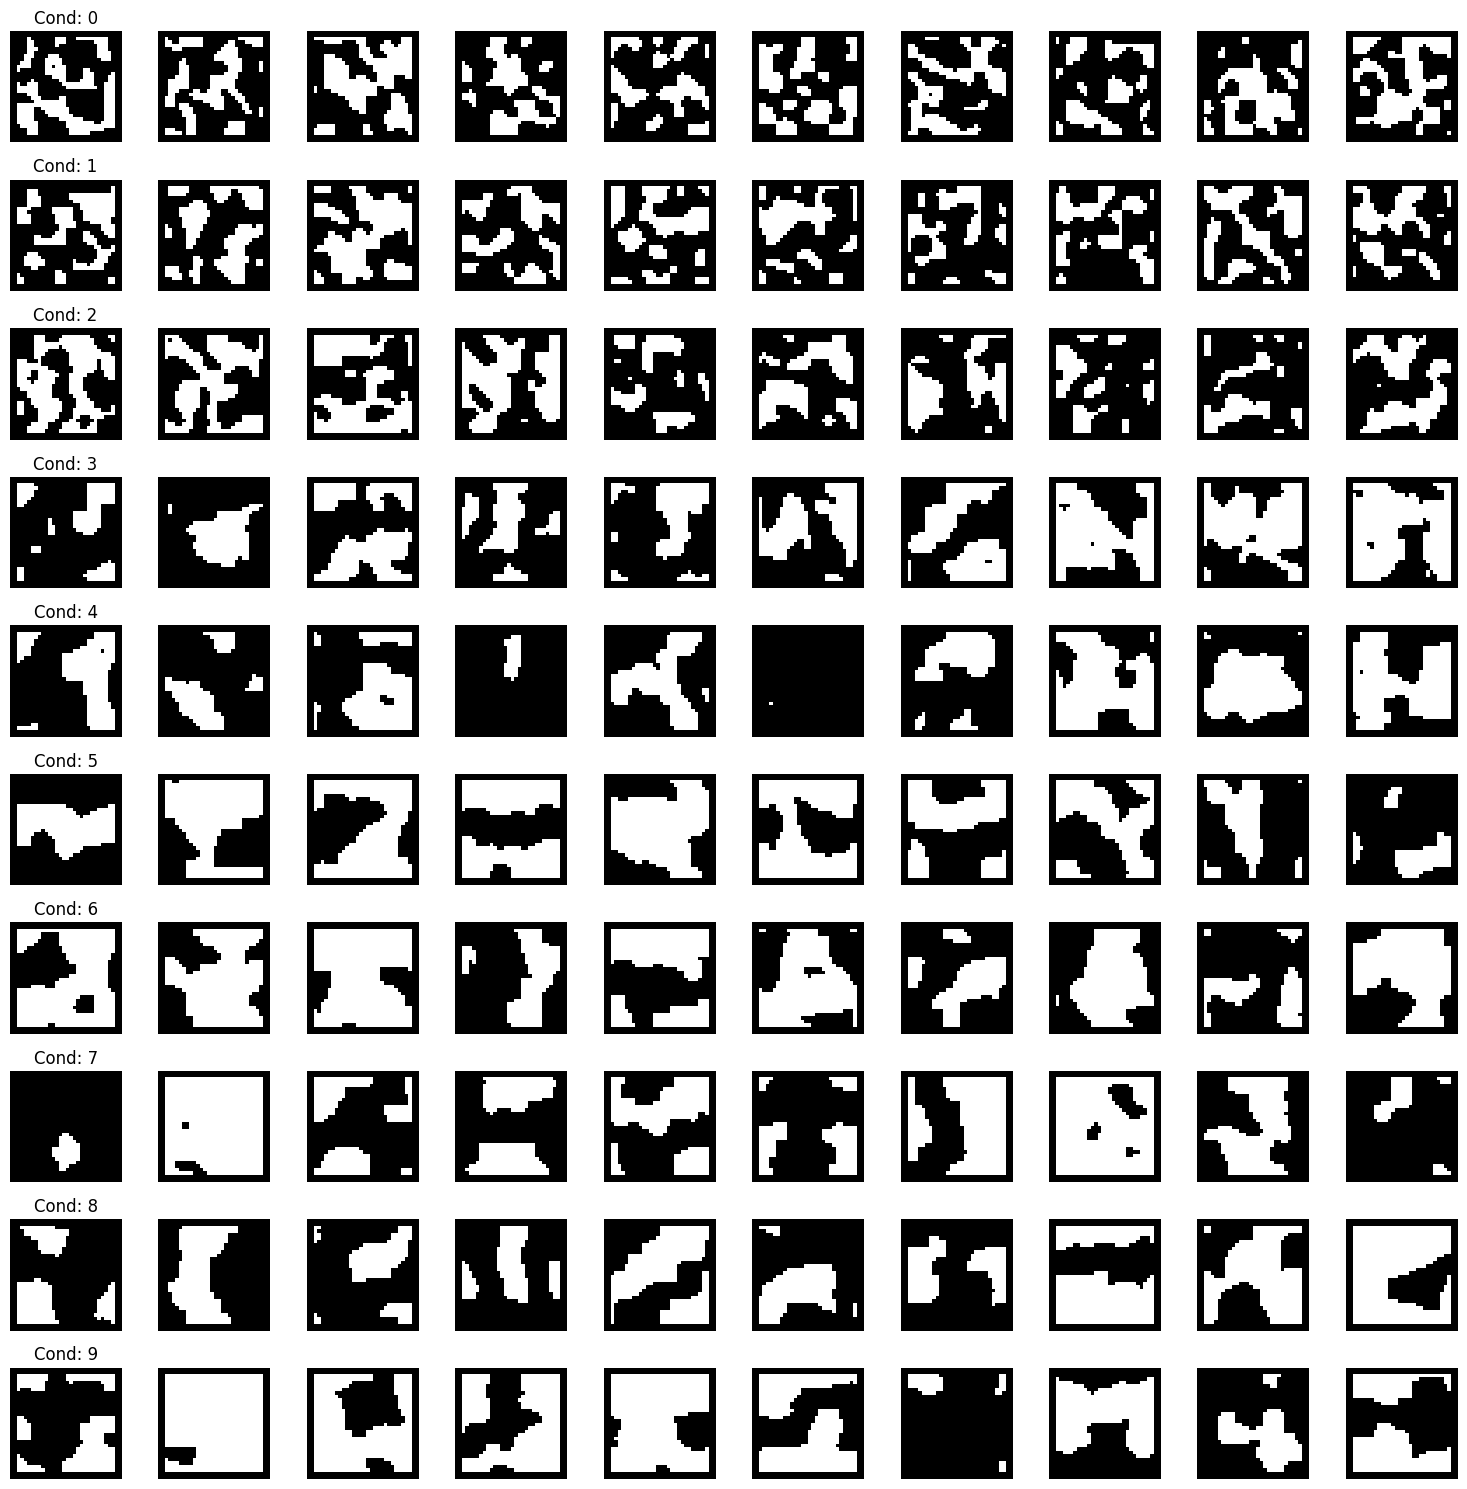

In [10]:
# Usage example:
num_conditions = 10  # Number of different conditions
num_replicates = 10  # Number of replicates per condition

# Generate samples
images, cond = sample_with_replicates(d3pm, num_conditions, num_replicates)

# Plot the final samples
plot_diffusion_grid_with_replicates(images[-1], cond, num_replicates)

In [11]:
import imageio
import numpy as np
from PIL import Image

def create_diffusion_gif(images, cond, num_replicates, output_path="diffusion.gif", fps=10):
    # Convert the tensor images to numpy arrays and normalize to 0-255 range
    frames = []
    num_timesteps = len(images)
    num_conditions = len(torch.unique(cond))
    
    # Create figure for each timestep
    for t in range(num_timesteps):
        fig, axes = plt.subplots(num_conditions, num_replicates, figsize=(15, 15))
        
        # Plot each image in the grid
        for i in range(num_conditions):
            for j in range(num_replicates):
                idx = i * num_replicates + j
                img = images[t][idx, 0].cpu().numpy()
                
                if num_conditions == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]
                    
                ax.imshow(img, cmap='gray')
                if j == 0:
                    ax.set_title(f'Cond: {cond[idx].item()}')
                ax.axis('off')
        
        plt.tight_layout()
        
        # Convert plot to image
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        
        plt.close()
    
    # Create optimized GIF
    imageio.mimsave(
        output_path,
        frames,
        fps=fps,
        optimize=True,
        subrectangles=True
    )

# Usage
num_conditions = 9
num_replicates = 10

# Generate samples
images, cond = sample_with_replicates(d3pm, num_conditions, num_replicates)

# Create GIF with optimized settings
create_diffusion_gif(
    images,
    cond,
    num_replicates,
    output_path="diffusion_process.gif",
    fps=15  # Adjust based on your needs
)

/tmp/ipykernel_4181707/592186716.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
